# Monte Carlo Simulation for DrawDown calculation

## Geometric Brownian Motion

For the stock price generation we will use GBM

#### Price
$$ S_k = S_{k-1}*e^{r} $$

>$ S_k $ -> price at k point

>$ S_{k-1} $ -> previouse price

>$ r $ -> return

#### Return
$$ r = drift + deffusion $$

> drift -> is a direction, we can interpret it as angle of the stock movement

> deffusion -> is a deviation from the mean price, from the drift. It is a noise. 

#### Drift
$$ drift = (\mu - \frac{1}{2}*\sigma^2) $$

>$ \mu $ -> mean of stock return

>$ \sigma $ -> standard deviation of stock return 

#### Deffusion
$$ deffusion = \sigma * Z[rand(0;1)] $$

>\sigma -> standart deviation of stock return

>Z[rand(0;1)] -> array of random variables (noise)

## Maximum DrawDown

$$ MDD = \frac{Trough Value - Peak Value}{Peak Value} $$



In [1]:
import numpy as np  
import pandas as pd  
import yfinance as yf
import matplotlib.pyplot as plt  
from scipy.stats import norm
%matplotlib inline

from numba import njit
import time

np.set_printoptions(precision=4)

In [2]:
ticker = 'SPY'
data = pd.DataFrame()
x = yf.Ticker(ticker)
data = yf.download(ticker, start="2015-01-01", end="2017-01-01")
price = data['Close']


[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

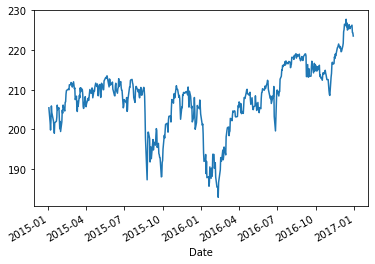

In [3]:
price.plot()

<AxesSubplot:xlabel='Date'>

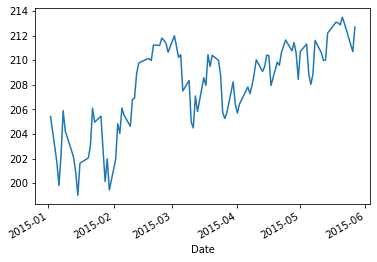

In [4]:
N = 100
Sp = 0
price_N = price[Sp:Sp+N]
price_N.plot()

### DrawDown calculation

In [5]:
# calculate maximum drawdown
# first impmelementaion
def max_drawdown_1(vec):
    maximums = np.maximum.accumulate(vec)
    drawdowns = 1 - vec / maximums
    return np.max(drawdowns)

#second implementaion using numba
@njit(fastmath=True)
def max_drawdown_2(ser):
    running_global_peak = ser[0]
    min_since_global_peak = ser[0]
    tmp_max_dd = 0
    running_max_dd_pct = 0
    for val in ser:        
        if val >= running_global_peak:
            running_global_peak = val
            min_since_global_peak = val
        if val < min_since_global_peak:
            min_since_global_peak = val
            tmp_max_dd = (val - running_global_peak) / running_global_peak
            if tmp_max_dd <= running_max_dd_pct:
                running_max_dd_pct = tmp_max_dd
    return running_max_dd_pct

#final implementaion
@njit(fastmath=True)
def MaxDrawdown(stock):
    mdd = 0.0
    maxPrev = stock[0]
    for i in range(1, len(stock)):
        mdd = np.fmax(mdd, (maxPrev - stock[i])/maxPrev)
        maxPrev = np.fmax(maxPrev, stock[i])
    return mdd

In [6]:
# lets check if we have the dame result from all three implementation
print(abs(max_drawdown_1(price_N.to_numpy())), abs(max_drawdown_2(price_N.to_numpy())), abs(MaxDrawdown(price_N.to_numpy())))

0.03533188027303291 0.03533188027303291 0.03533188027303291


In [7]:
from timeit import default_timer as timer
from datetime import timedelta
import timeit

LOOPS = 100000 #for time measurement
MPL = 1000000 # for miliseconds

In [8]:
result = (timeit.timeit(lambda: max_drawdown_1(price.to_numpy()), number=LOOPS) / LOOPS) *MPL
print("max_drawdown_1: {} µs".format( result ) )

result = (timeit.timeit(lambda: max_drawdown_2(price.to_numpy()), number=LOOPS) / LOOPS) *MPL
print("max_drawdown_2: {} µs".format( result ) )

result = (timeit.timeit(lambda: MaxDrawdown(price.to_numpy()), number=LOOPS) / LOOPS) *MPL
print("MaxDrawdown: {} µs".format( result ) )

max_drawdown_1: 16.77065760000005 µs
max_drawdown_2: 3.575194160002866 µs
MaxDrawdown: 4.77212032999887 µs


### Calculation of the price serie charachteristics

In [9]:

# Parameter Definitions

# S0    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns

S0 = price_N[0]
dt = 1
T = 100
N = int(T/dt)
t = np.arange(1, int(N) + 1)
mu = np.log1p(price_N.pct_change()).mean()
sigma = np.log1p(price_N.pct_change()).std()

print('Initial Prameters:')
print('S0: ', S0)
print('dt: ', dt)
print('T:  ', T)
print('N:  ', N)
print('mu: ', mu)
print('sigma: ', sigma)


Initial Prameters:
S0:  205.42999267578125
dt:  1
T:   100
N:   100
mu:  0.00035128687077953227
sigma:  0.00781510977845114


### Monte Carlo: Price Path Generation

In [10]:
#generate price path
def monteCarloGenerateNPathes(S0, mu, sigma, seed, N, N_PATH):
    x = []
    for i in range(N_PATH):
        np.random.seed(seed + i)
        S_final = [] # all price points
        W = 0
        for k in range(1,N+1):
            W += np.random.normal(0, 1)
            drift = (mu - 0.5 * sigma**2) * k #for k data point
            diffusion = sigma * W  #for k data point

            S = S0*np.exp(drift + diffusion) 

            S_final.append(S)
        
        x.append(S_final)
    return x


<AxesSubplot:>

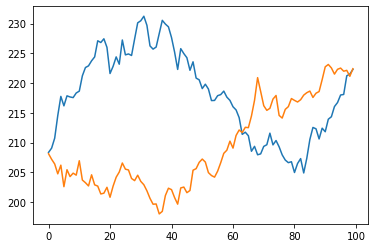

In [11]:
#generate two new price pathes from the given price serie characteristic 
N_PATH = 2 # one path
N = 100 # 100 price points
seed = 0

x = monteCarloGenerateNPathes(S0,mu, sigma, seed, N, N_PATH)
pd.DataFrame(np.array(x).T).plot(legend = False)

<AxesSubplot:>

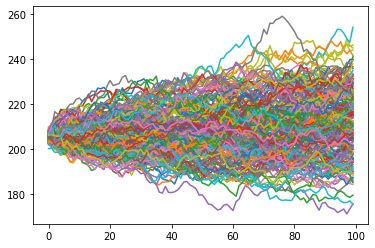

In [12]:
#generate 200 new price pathes from the given price serie characteristic 
N_PATH = 200 # 
N = 100 # 
seed = 0

x = monteCarloGenerateNPathes(S0, mu, sigma, seed, N, N_PATH)
pd.DataFrame(np.array(x).T).plot(legend = False)

### Monte Carlo: MDD

In [13]:
# streight forward montecarlo implementaion
def monteCarloMdd_0(S0, mu, sigma, seed, N, N_PATH):
    x = []
    for i in range(N_PATH):
        np.random.seed(seed + i)
        S_final = [] # all price points for one path
        W = 0
        for k in range(1,N+1):
            W += np.random.normal(0, 1) #generate random value
            drift = (mu - 0.5 * sigma**2) * k #for k data point
            diffusion = sigma * W  #for k data point

            S = S0*np.exp(drift + diffusion) #calculate one price point

            S_final.append(S)
        
        x.append(MaxDrawdown(np.array(S_final)))
    return np.mean(x)

In [14]:
N_PATH = 10000
N = 100

mdd_from_history = MaxDrawdown(price_N.to_numpy())*100
mdd_0 = monteCarloMdd_0(S0, mu, sigma, 0, int(N), N_PATH)*100

print("Historical MDD: {:.2f}%".format(mdd_from_history))
print("Estimated  MDD: {:.2f}%".format(mdd_0))

print("Real expected risk in {:.2f} times higher than we have calculated from the historical data".format(mdd_0/mdd_from_history))

Historical MDD: 3.53%
Estimated  MDD: 7.31%
Real expected risk in 2.07 times higher than we have calculated from the historical data


### MonteCarlo performance measurement

In [15]:
N_PATH = 10000
N = 100

In [16]:
LOOPS = 20

mdd_0_time = (timeit.timeit(lambda: monteCarloMdd_0(S0, mu, sigma, 0, int(N), N_PATH), number=LOOPS) / LOOPS) 
print("execution time: {:.6f} s".format( mdd_0_time ) )

print("Estimated MDD: {:.2f}%".format( monteCarloMdd_0(S0, mu, sigma, 0, int(N), N_PATH) * 100) )

execution time: 7.704623 s
Estimated MDD: 7.31%


### Monte Carlo Code Improvement

In [17]:
# streight forward solution with modifiaction
# instead of random for each new price point, we can generate the random
# values for all N points in one shot before price calculation
def monteCarloMdd_1(S0, mu, sigma, seed, N, N_PATH):
    x = []
    for i in range(N_PATH):
        np.random.seed(seed + i)
        S_final = [] # all price points
        b = np.random.normal(0, 1, int(N))  #<---- generate array or randoms
        W = 0
        for k in range(N):
            W += b[k] #cumsum <--- access to the value directly insted of generation
            drift = (mu - 0.5 * sigma**2) * (k+1) #for k data point
            diffusion = sigma * W #for k data point

            S = S0*np.exp(drift + diffusion) #calculate one price point

            S_final.append(S)

        x.append(MaxDrawdown(np.array(S_final)))
    return np.mean(x)

In [18]:
mdd_1_time = (timeit.timeit(lambda: monteCarloMdd_1(S0, mu, sigma, 0, int(N), N_PATH), number=LOOPS) / LOOPS) 
print("execution time: {:.6f} s".format( mdd_1_time ) )

print("Estimated MDD: {:.2f}%".format( monteCarloMdd_1(S0, mu, sigma, 0, int(N), N_PATH) * 100) )

execution time: 3.453670 s
Estimated MDD: 7.31%


In [19]:
print("Improvements: in {:.2f} times".format(mdd_0_time/mdd_1_time))

Improvements: in 2.23 times


In [20]:
# simple vectorized
# remove one loop
# W is a cumulative sum of our returns, so we can calculate it earlier using numpy function cumsum
def monteCarloMdd_2(S0, mu, sigma, seed, N, N_PATH):
    x = []
    t = np.arange(1, int(N) + 1)
    for i in range(N_PATH):
        np.random.seed(seed + i)
        b = np.random.normal(0, 1, int(N)) 
        W = np.cumsum(b)  #<--- calculate cumsum (array)
        drift = (mu - 0.5 * (sigma**2)) * t #for all data points
        diffusion = sigma * W # calculate deffusion in one shot -> output an array 

        S = S0*np.exp(drift + diffusion) #<--- generate all price points

        x.append(MaxDrawdown(np.array(S)))

    return np.mean(x)

In [21]:
mdd_2_time = (timeit.timeit(lambda: monteCarloMdd_2(S0, mu, sigma, 0, int(N), N_PATH), number=LOOPS) / LOOPS) 
print("execution time: {:.6f} s".format( mdd_2_time ) )

print("Estimated MDD: {:.2f}%".format( monteCarloMdd_2(S0, mu, sigma, 0, int(N), N_PATH) * 100) )

execution time: 0.292948 s
Estimated MDD: 7.31%


In [22]:
print("Iprovements from the 0 version: faster in {:.2f} times".format(mdd_0_time/mdd_2_time))
print("Iprovements from the 1 version: faster in {:.2f} times".format(mdd_1_time/mdd_2_time))

Iprovements from the 0 version: faster in 26.30 times
Iprovements from the 1 version: faster in 11.79 times


In [23]:
def monteCarloMdd_3(S0,  mu, sigma, seed, N_STEPS, N_PATHS):
    
    drift = (mu - 0.5 * (sigma**2))
    output =  np.zeros(N_PATHS, dtype=np.float32)
    d_normals = np.random.normal(0, 1, N_PATHS * N_STEPS)
    np.random.seed(seed)
    
    for i in range(N_PATHS):
        S = 0.0
        mdd = 0.0;
        maxPrev = S0
        W = 0.0

        for k in range(1, N_STEPS+1):
            index = (k-1) + (i) * N_STEPS
            W += d_normals[index]
            S = S0*np.exp((drift * k) + (sigma*W))
            
            mdd = np.fmax(mdd, (maxPrev - S)/maxPrev)
            maxPrev = np.fmax(maxPrev, S)
        
        output[i] = mdd;

    return np.mean(output)


In [24]:
mdd_3_time = (timeit.timeit(lambda: monteCarloMdd_3(S0, mu, sigma, 0, int(N), N_PATH), number=LOOPS) / LOOPS) 
print("execution time: {:.6f} s".format( mdd_3_time ) )

print("Estimated MDD: {:.2f}%".format( monteCarloMdd_3(S0, mu, sigma, 0, int(N), N_PATH) * 100) )

execution time: 7.678923 s
Estimated MDD: 7.31%


In [25]:
print("Iprovements from the 0 version: faster in {:.2f} times".format(mdd_0_time/mdd_3_time))
print("Iprovements from the 1 version: faster in {:.2f} times".format(mdd_1_time/mdd_3_time))
print("Iprovements from the 2 version: faster in {:.2f} times".format(mdd_2_time/mdd_3_time))

Iprovements from the 0 version: faster in 1.00 times
Iprovements from the 1 version: faster in 0.45 times
Iprovements from the 2 version: faster in 0.04 times


### Monte Carlo implementation with Numba decorator

In [26]:
#let's try to use numba without any code change
@njit(fastmath=True)
def monteCarloMdd_0_numba(S0, mu, sigma, seed, N, N_PATH):
    x = []
    for i in range(N_PATH):
        np.random.seed(seed + i)
        S_final = [] # all price points for one path
        W = 0
        for k in range(N):
            W += np.random.normal(0, 1) #generate random value
            drift = (mu - 0.5 * sigma**2) * k #for k data point
            diffusion = sigma * W  #for k data point

            S = S0*np.exp(drift + diffusion) #calculate one price point

            S_final.append(S)
        
        x.append(MaxDrawdown(np.array(S_final)))
    return x

#simple vectorized
@njit(fastmath=True)
def monteCarloMdd_1_numba(S0, mu, sigma, seed, N, N_PATH):
    x = []
    for i in range(N_PATH):
        np.random.seed(seed + i)
        S_final = [] # all price points
        b = np.random.normal(0, 1, int(N))  #<---- generate array or randoms
        W = 0
        for k in range(int(N)):
            W += b[k] #cumsum <--- access to the value directly insted of generation
            drift = (mu - 0.5 * sigma**2) * k #for k data point
            diffusion = sigma * W #for k data point

            S = S0*np.exp(drift + diffusion) #calculate one price point 

            S_final.append(S)

        x.append(MaxDrawdown(np.array(S_final)))

    
    return x

@njit(fastmath=True)
def monteCarloMdd_2_numba(S0, mu, sigma, seed, N, N_PATH):
    x = []
    t = np.arange(1, int(N) + 1)
    for i in range(N_PATH):
        np.random.seed(seed + i)
        b = np.random.normal(0, 1, int(N)) 
        W = np.cumsum(b)  #<--- calculate cumsum (array)
        drift = (mu - 0.5 * sigma**2) * t #for all data points
        diffusion = sigma * W # calculate deffusion in one shot -> output an array 

        S = S0*np.exp(drift + diffusion) #<--- generate all price points

        x.append(MaxDrawdown(S))

    return x

@njit(fastmath=True)
def monteCarloMdd_3_numba(output, S0,  mu, sigma, N_STEPS, N_PATHS, d_normals):
    drift = (mu - 0.5 * sigma*sigma)
    for i in range(N_PATHS):
        S = 0.0
        mdd = 0.0
        maxPrev = S0
        W = 0.0
        for k in range(1, N_STEPS+1):
            index = (k-1) + (i) * N_STEPS
            W += d_normals[index]
            S = S0*np.exp((drift * k) + (sigma*W))
            mdd = np.fmax(mdd, (maxPrev - S)/maxPrev)
            maxPrev = np.fmax(maxPrev, S)
        output[i] = mdd
    
def getMDD_monteCarloMdd_3_numba(S0, mu, sigma, seed=0, N_STEPS = 100, N_PATHS = 1000000):
   
    np.random.seed(seed)
    randoms_d = np.random.normal(0, 1, N_PATHS * N_STEPS)
    output =  np.zeros(N_PATHS, dtype=np.float32)
    
    monteCarloMdd_3_numba(output, S0, mu, sigma, N_STEPS, N_PATHS, randoms_d)
    return np.mean(output)

In [27]:
LOOPS = 100
mdd_0_time_numba = (timeit.timeit(lambda: monteCarloMdd_0_numba(S0, mu, sigma, 0, int(N), N_PATH), number=LOOPS) / LOOPS) 
print("execution time: {:.6f} s".format( mdd_0_time_numba ) )

print("Estimated MDD: {:.2f}%".format( np.mean(monteCarloMdd_0_numba(S0, mu, sigma, 0, int(N), N_PATH)) * 100) )

execution time: 0.064197 s
Estimated MDD: 7.31%


In [28]:
print("Iprovements from the 0 version: faster in {:.2f} times".format(mdd_0_time/mdd_0_time_numba))
print("Iprovements from the 1 version: faster in {:.2f} times".format(mdd_1_time/mdd_0_time_numba))
print("Iprovements from the 2 version: faster in {:.2f} times".format(mdd_2_time/mdd_0_time_numba))

Iprovements from the 0 version: faster in 120.02 times
Iprovements from the 1 version: faster in 53.80 times
Iprovements from the 2 version: faster in 4.56 times


In [29]:
mdd_1_time_numba = (timeit.timeit(lambda: monteCarloMdd_1_numba(S0, mu, sigma, 0, int(N), N_PATH), number=LOOPS) / LOOPS) 
print("execution time: {:.6f} s".format( mdd_1_time_numba ) )

print("Estimated MDD: {:.2f}%".format( np.mean(monteCarloMdd_1_numba(S0, mu, sigma, 0, int(N), N_PATH)) * 100) )

execution time: 0.059731 s
Estimated MDD: 7.31%


In [30]:
print("Iprovements from the 0 version: faster in {:.2f} times".format(mdd_0_time/mdd_1_time_numba))
print("Iprovements from the 1 version: faster in {:.2f} times".format(mdd_1_time/mdd_1_time_numba))
print("Iprovements from the 2 version: faster in {:.2f} times".format(mdd_2_time/mdd_1_time_numba))
print("Iprovements from the 0_numba version: faster in {:.2f} times".format(mdd_0_time_numba/mdd_1_time_numba))

Iprovements from the 0 version: faster in 128.99 times
Iprovements from the 1 version: faster in 57.82 times
Iprovements from the 2 version: faster in 4.90 times
Iprovements from the 0_numba version: faster in 1.07 times


In [31]:
mdd_2_time_numba = (timeit.timeit(lambda: monteCarloMdd_2_numba(S0, mu, sigma, 0, int(N), N_PATH), number=LOOPS) / LOOPS) 
print("execution time: {:.6f} s".format( mdd_2_time_numba ) )

print("Estimated MDD: {:.2f}%".format( np.mean(monteCarloMdd_2_numba(S0, mu, sigma, 0, int(N), N_PATH)) * 100) )

execution time: 0.071120 s
Estimated MDD: 7.31%


In [32]:
print("Iprovements from the 0 version: faster in {:.2f} times".format(mdd_0_time/mdd_2_time_numba))
print("Iprovements from the 1 version: faster in {:.2f} times".format(mdd_1_time/mdd_2_time_numba))
print("Iprovements from the 2 version: faster in {:.2f} times".format(mdd_2_time/mdd_2_time_numba))
print("Iprovements from the 0_numba version: faster in {:.2f} times".format(mdd_0_time_numba/mdd_2_time_numba))
print("Iprovements from the 1_numba version: faster in {:.2f} times".format(mdd_1_time_numba/mdd_2_time_numba))

Iprovements from the 0 version: faster in 108.33 times
Iprovements from the 1 version: faster in 48.56 times
Iprovements from the 2 version: faster in 4.12 times
Iprovements from the 0_numba version: faster in 0.90 times
Iprovements from the 1_numba version: faster in 0.84 times


In [33]:
mdd_3_time_numba = (timeit.timeit(lambda: getMDD_monteCarloMdd_3_numba(S0, mu, sigma, 0, int(N), N_PATH), number=LOOPS) / LOOPS) 
print("execution time: {:.6f} s".format( mdd_3_time_numba ) )

print("Estimated MDD: {:.2f}%".format( np.mean(getMDD_monteCarloMdd_3_numba(S0, mu, sigma, 0, int(N), N_PATH)) * 100) )

execution time: 0.043351 s
Estimated MDD: 7.31%


In [34]:
print("Iprovements from the 0 version: faster in {:.2f} times".format(mdd_0_time/mdd_3_time_numba))
print("Iprovements from the 1 version: faster in {:.2f} times".format(mdd_1_time/mdd_3_time_numba))
print("Iprovements from the 2 version: faster in {:.2f} times".format(mdd_2_time/mdd_3_time_numba))
print("Iprovements from the 0_numba version: faster in {:.2f} times".format(mdd_0_time_numba/mdd_3_time_numba))
print("Iprovements from the 1_numba version: faster in {:.2f} times".format(mdd_1_time_numba/mdd_3_time_numba))
print("Iprovements from the 2_numba version: faster in {:.2f} times".format(mdd_2_time_numba/mdd_3_time_numba))

Iprovements from the 0 version: faster in 177.73 times
Iprovements from the 1 version: faster in 79.67 times
Iprovements from the 2 version: faster in 6.76 times
Iprovements from the 0_numba version: faster in 1.48 times
Iprovements from the 1_numba version: faster in 1.38 times
Iprovements from the 2_numba version: faster in 1.64 times


In [35]:
### try GPU
from numba import cuda
import math

LOOPS = 1000

In [36]:
@cuda.jit(fastmath=True)
def monteCarloMdd_3_numba_cuda(output, S0,  mu, sigma, N_STEPS, N_PATHS, d_normals):

    idx =  cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.blockDim.x * cuda.gridDim.x
    tid = cuda.threadIdx.x
    
    drift = (mu - 0.5 * sigma*sigma)
 
    for i in range(idx, N_PATHS, stride):
        S = 0.0
        mdd = 0.0
        maxPrev = S0
        W = 0.0

        for k in range(1, N_STEPS+1):
            index = (k-1) + (i) * N_STEPS
            W += d_normals[index]
            S = S0*math.exp((drift * k) + (sigma*W))
            
            mdd = max(mdd, (maxPrev - S)/maxPrev)
            maxPrev = max(maxPrev, S)
        
        output[i] = mdd
    
def getMDD_monteCarloMdd_3_numba_cuda(S0, mu, sigma, seed=0, N_STEPS = 100, N_PATHS = 1000000):

    number_of_threads = 56
    number_of_blocks = (N_PATHS-1) // number_of_threads + 1
   
    np.random.seed(seed)
    randoms_d = np.random.normal(0, 1, N_PATHS * N_STEPS)
    d_randoms_d = cuda.to_device(randoms_d)

    output =  np.zeros(N_PATHS, dtype=np.float32)
    d_output = cuda.to_device(output)
    
    monteCarloMdd_3_numba_cuda[number_of_blocks, number_of_threads](d_output, 
                    S0, mu, sigma, N_STEPS, N_PATHS, d_randoms_d)
    
    return np.mean(d_output)    


In [37]:
mdd_3_time_numba_cuda = (timeit.timeit(lambda: getMDD_monteCarloMdd_3_numba_cuda(S0, mu, sigma, 0, int(N), N_PATH), number=LOOPS) / LOOPS) 
print("execution time: {:.6f} s".format( mdd_3_time_numba_cuda ) )

print("Estimated MDD: {:.2f}%".format( np.mean(getMDD_monteCarloMdd_3_numba_cuda(S0, mu, sigma, 0, int(N), N_PATH)) * 100) )

execution time: 0.029230 s
Estimated MDD: 7.31%


In [38]:
print("Iprovements from the 0 version: faster in {:.2f} times".format(mdd_0_time/mdd_3_time_numba_cuda))
print("Iprovements from the 1 version: faster in {:.2f} times".format(mdd_1_time/mdd_3_time_numba_cuda))
print("Iprovements from the 2 version: faster in {:.2f} times".format(mdd_2_time/mdd_3_time_numba_cuda))
print("Iprovements from the 0_numba version: faster in {:.2f} times".format(mdd_0_time_numba/mdd_3_time_numba_cuda))
print("Iprovements from the 1_numba version: faster in {:.2f} times".format(mdd_1_time_numba/mdd_3_time_numba_cuda))
print("Iprovements from the 2_numba version: faster in {:.2f} times".format(mdd_2_time_numba/mdd_3_time_numba_cuda))
print("Iprovements from the 3_numba version: faster in {:.2f} times".format(mdd_2_time_numba/mdd_3_time_numba_cuda))

Iprovements from the 0 version: faster in 263.59 times
Iprovements from the 1 version: faster in 118.16 times
Iprovements from the 2 version: faster in 10.02 times
Iprovements from the 0_numba version: faster in 2.20 times
Iprovements from the 1_numba version: faster in 2.04 times
Iprovements from the 2_numba version: faster in 2.43 times
Iprovements from the 3_numba version: faster in 2.43 times


In [39]:
#let's try cuda dask

In [40]:
import cupy
import cudf
import dask_cudf
from dask import delayed
import numpy as np
import pandas as pd
import math

from dask_cuda import LocalCUDACluster
from dask.distributed import Client

LOOPS = 10000

/root/miniconda3/envs/rapids_env/lib/python3.8/site-packages/cupy/_environment.py:434: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda112, cupy-cuda115

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [41]:
import cupy
cupy_simple_mc_mdd = cupy.RawKernel(r'''
extern "C" __global__ void simple_mc_mdd(
    float *d_s,
    const float S0,
    const float mu,
    const float sigma,
    const long N,
    const long N_PATHS,
    const float * d_normals)
{
  unsigned idx =  threadIdx.x + blockIdx.x * blockDim.x;
  unsigned stride = blockDim.x * gridDim.x;
  unsigned tid = threadIdx.x;

  const double drift_0 = (mu - 0.5 * (sigma*sigma));
  int index = 0;
 
  for (unsigned i = idx; i<N_PATHS; i+=stride)
  {
    float S;
    float mdd = 0.0;
    float maxPrev = S0;
    float W = 0.0;
    
    for (int k=1; k<=N; ++k) 
    {
      index = (k-1) + (i) * N;
      W += d_normals[index];
      S = S0*expf((drift_0 * k) + (sigma*W));
      mdd = fmaxf(mdd, (maxPrev - S)/maxPrev);
      maxPrev = fmaxf(maxPrev, S);
    }
    d_s[i] = mdd;
  }
}
''', 'simple_mc_mdd')

In [42]:
def get_mdd(S0, mu, sigma, seed=0, N_STEPS = 100, N_PATHS = 1000000):
    number_of_threads = 52
    number_of_blocks = (N_PATHS-1) // number_of_threads + 1
    cupy.random.seed(seed)
    randoms_gpu = cupy.random.normal(0, 1, N_PATHS * N_STEPS, dtype=cupy.float32)
    output =  cupy.zeros(N_PATHS, dtype=cupy.float32)
    
    cupy_simple_mc_mdd((number_of_blocks,), (number_of_threads,),
                   (output, 
                    np.float32(S0), 
                    np.float32(mu), 
                    np.float32(sigma), 
                    N_STEPS, 
                    N_PATHS, 
                    randoms_gpu))
    v = output.mean()
    out_df = cudf.DataFrame()
    out_df['p'] = cudf.Series([v.item()])
    
    return out_df 
    
#    return output.mean().item()

In [43]:
mdd_dask_cuda = (timeit.timeit(lambda: get_mdd(S0, mu, sigma, 0, int(N), N_PATH), number=LOOPS) / LOOPS) 
print("execution time: {:.6f} s".format( mdd_dask_cuda ) )

print("Estimated MDD: {:.2f}%".format( get_mdd(S0, mu, sigma, 0, int(N), N_PATH)['p'].iloc[0] * 100) )

execution time: 0.003933 s
Estimated MDD: 7.35%


In [44]:
print("Iprovements from the 0 version: faster in {:.2f} times".format(mdd_0_time/mdd_dask_cuda))
print("Iprovements from the 1 version: faster in {:.2f} times".format(mdd_1_time/mdd_dask_cuda))
print("Iprovements from the 2 version: faster in {:.2f} times".format(mdd_2_time/mdd_dask_cuda))
print("Iprovements from the 0_numba version: faster in {:.2f} times".format(mdd_0_time_numba/mdd_dask_cuda))
print("Iprovements from the 1_numba version: faster in {:.2f} times".format(mdd_1_time_numba/mdd_dask_cuda))
print("Iprovements from the 2_numba version: faster in {:.2f} times".format(mdd_2_time_numba/mdd_dask_cuda))
print("Iprovements from the 3_numba version: faster in {:.2f} times".format(mdd_2_time_numba/mdd_dask_cuda))
print("Iprovements from the 3_numba_cuda version: faster in {:.2f} times".format(mdd_3_time_numba_cuda/mdd_dask_cuda))

Iprovements from the 0 version: faster in 1959.14 times
Iprovements from the 1 version: faster in 878.20 times
Iprovements from the 2 version: faster in 74.49 times
Iprovements from the 0_numba version: faster in 16.32 times
Iprovements from the 1_numba version: faster in 15.19 times
Iprovements from the 2_numba version: faster in 18.08 times
Iprovements from the 3_numba version: faster in 18.08 times
Iprovements from the 3_numba_cuda version: faster in 7.43 times


In [45]:
#add more simulated math for numba implementation to get the same mdd result
# I guess it is because of my numba version or processor, with another environment and pc
# the result is always equal with cupy cuda and other implementaions
print("Estimated MDD: {:.2f}%".format( np.mean(getMDD_monteCarloMdd_3_numba_cuda(S0, mu, sigma, 0, int(N), 100000)) * 100) )

Estimated MDD: 7.35%


In [46]:
# we can also use dask to execute our simulation n times
# below we execute our simulation with the 10000 paths 100 times
# you may notice that execution of cupy cuda kernel is much much fater than numba

In [47]:
%%timeit
k = [delayed(get_mdd)(S0, mu, sigma, i, int(N), N_PATH) for i in  range(100)]
x = dask_cudf.from_delayed(k).compute()
x.mean()

653 ms ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
k = [delayed(get_mdd)(S0, mu, sigma, i, int(N), N_PATH) for i in  range(100)]
x = dask_cudf.from_delayed(k).compute()
x.mean()*100

p    7.355461
dtype: float64

In [49]:
def getMDD_monteCarloMdd_3_numba_cuda2(S0, mu, sigma, seed=0, N_STEPS = 100, N_PATHS = 1000000):

    number_of_threads = 56
    number_of_blocks = (N_PATHS-1) // number_of_threads + 1
   
    np.random.seed(seed)
    randoms_d = np.random.normal(0, 1, N_PATHS * N_STEPS)
    d_randoms_d = cuda.to_device(randoms_d)

    output =  np.zeros(N_PATHS, dtype=np.float32)
    d_output = cuda.to_device(output)
    
    monteCarloMdd_3_numba_cuda[number_of_blocks, number_of_threads](d_output, 
                    S0, mu, sigma, N_STEPS, N_PATHS, d_randoms_d)
    
    out_df = cudf.DataFrame()
    out_df['p'] = cudf.Series([np.mean(d_output)])    
    return out_df

In [50]:
%%timeit
k = [delayed(getMDD_monteCarloMdd_3_numba_cuda2)(S0, mu, sigma, i, int(N), N_PATH) for i in  range(100)]
x = dask_cudf.from_delayed(k).compute()
x.mean()

3.23 s ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
k = [delayed(getMDD_monteCarloMdd_3_numba_cuda2)(S0, mu, sigma, i, int(N), N_PATH) for i in  range(100)]
x = dask_cudf.from_delayed(k).compute()
x.mean()*100

p    7.350281
dtype: float64